# Analysis of the Sensitivity with respect to the Dataset Size

## Preamble

In [1]:
import torch
import gpytorch
import numpy as np

%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from importlib.resources import files

from manifold_gp.kernels.riemann_matern_kernel import RiemannMaternKernel
from manifold_gp.models.riemann_gp import RiemannGP
from manifold_gp.models.vanilla_gp import VanillaGP
from manifold_gp.utils.mesh_helper import groundtruth_from_samples
from manifold_gp.utils.file_read import get_data

from manifold_gp.priors.inverse_gamma_prior import InverseGammaPrior
from gpytorch.priors import NormalPrior, GammaPrior

## Dataset Preprocessing

In [2]:
data_path = files('manifold_gp.data').joinpath('dumbbell.msh')
data = get_data(data_path, "Nodes", "Elements")

vertices = data['Nodes'][:, 1:-1]
edges = data['Elements'][:, -2:].astype(int) - 1
truth, geodesics = groundtruth_from_samples(vertices,edges)

sampled_x = torch.from_numpy(vertices).float()
sampled_y = torch.from_numpy(truth).float()
(m, n) = sampled_x.shape

torch.manual_seed(1337)
rand_idx = torch.randperm(m)

sampled_x, sampled_y = sampled_x.contiguous(), sampled_y.contiguous()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
sampled_x, sampled_y = sampled_x.to(device), sampled_y.to(device)

## Semi-Supervised

In [3]:
rmse_log_ss = []
nll_log_ss = []

likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-8),
    noise_prior=None
)

kernel = gpytorch.kernels.ScaleKernel(
    RiemannMaternKernel(
        nu=1,
        nodes=sampled_x,
        neighbors=10,
        operator="randomwalk",
        modes=50,
        ball_scale=3.0,
        prior_bandwidth=False,
        lengthscale_prior=None
    ),
    outputscale_prior=None
)

for split in range(10,100,20):
    train_idx = rand_idx[:split]
    train_x, train_y = sampled_x[train_idx, :], sampled_y[train_idx]
    train_y += 0.01 * torch.randn(split).to(device)
    mu_y, std_y = train_y.mean(), train_y.std()
    train_y.sub_(mu_y).div_(std_y)

    model = RiemannGP(train_x, train_y, likelihood, kernel, train_idx).to(device)

    hypers = {
        'likelihood.noise_covar.noise': 1e-2,
        'covar_module.base_kernel.epsilon': 0.5,
        'covar_module.base_kernel.lengthscale': 1.0,
        'covar_module.outputscale': 1.0,
    }
    model.initialize(**hypers)
    model.manifold_informed_train(lr=1e-1, iter=100, verbose=False)

    likelihood.eval()
    model.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds_test = likelihood(model(sampled_x))

        error = sampled_y.sub_(mu_y).div_(std_y) - preds_test.mean
        covar = preds_test.lazy_covariance_matrix.evaluate_kernel()
        inv_quad, logdet = covar.inv_quad_logdet(inv_quad_rhs=error.unsqueeze(-1), logdet=True)

        rmse_log_ss.append((error.square().sum()/m).sqrt().cpu())
        nll_log_ss.append((0.5 * sum([inv_quad, logdet, error.size(-1)* np.log(2 * np.pi)])/m).cpu())
        model._clear_cache()

## Vanilla

In [4]:
rmse_log_v = []
nll_log_v = []

for split in range(10,100,20):
    train_idx = rand_idx[:split]
    train_x, train_y = sampled_x[train_idx, :], sampled_y[train_idx]
    train_y += 0.01 * torch.randn(split).to(device)
    mu_y, std_y = train_y.mean(), train_y.std()
    train_y.sub_(mu_y).div_(std_y)

    model = VanillaGP(
        train_x, 
        train_y, 
        gpytorch.likelihoods.GaussianLikelihood(), 
        gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))
    ).to(device)

    hypers = {
        'likelihood.noise_covar.noise': 1e-2,
        'covar_module.base_kernel.lengthscale': 1.0,
        'covar_module.outputscale': 1.0,
    }
    model.initialize(**hypers)
    model.vanilla_train(lr=1e-1, iter=100, verbose=False)

    model.likelihood.eval()
    model.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.cg_tolerance(10000):
        preds_test = likelihood(model(sampled_x))

        error = sampled_y.sub_(mu_y).div_(std_y) - preds_test.mean
        covar = preds_test.lazy_covariance_matrix.evaluate_kernel()
        inv_quad, logdet = covar.inv_quad_logdet(inv_quad_rhs=error.unsqueeze(-1), logdet=True)

        rmse_log_v.append((error.square().sum()/m).sqrt().cpu())
        nll_log_v.append((0.5 * sum([inv_quad, logdet, error.size(-1)* np.log(2 * np.pi)])/m).cpu())
        model._clear_cache()

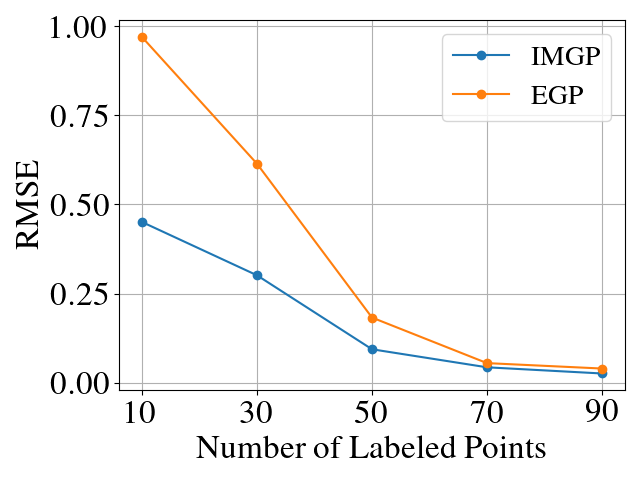

In [9]:
# Enable LaTeX rendering
mpl.rcParams['text.usetex'] = True

# Set Times as the font family
mpl.rcParams['font.family'] = 'Times'

# Create figure and axes
fig, ax = plt.subplots()

# Data
x = np.arange(10,100,20)
y1 = np.array(rmse_log_ss)
y2 = np.array(rmse_log_v)

# Plot lines with markers
ax.plot(x, y1, '-o', label='IMGP')
ax.plot(x, y2, '-o', label='EGP')

# Set x-axis and y-axis labels
ax.set_xlabel('Number of Labeled Points', fontsize=24)
ax.set_ylabel('RMSE', fontsize=24)

# Set x-axis ticks at specific values
ax.set_xticks(x)

# Increase tick label sizes
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)

# Set legend
ax.legend(fontsize=20)

# Set grid
ax.grid(True)

# Adjust layout
fig.tight_layout()

# Save the plot
plt.savefig('dataset_analysis_rmse.png', format='png')

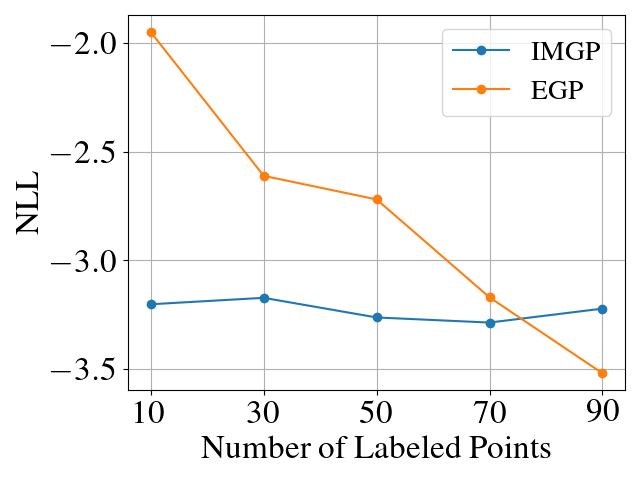

In [10]:
# Enable LaTeX rendering
mpl.rcParams['text.usetex'] = True

# Set Times as the font family
mpl.rcParams['font.family'] = 'Times'

# Create figure and axes
fig, ax = plt.subplots()

# Data
x = np.arange(10,100,20)
y1 = np.array(nll_log_ss)
y2 = np.array(nll_log_v)

# Plot lines with markers
ax.plot(x, y1, '-o', label='IMGP')
ax.plot(x, y2, '-o', label='EGP')

# Set x-axis and y-axis labels
ax.set_xlabel('Number of Labeled Points', fontsize=24)
ax.set_ylabel('NLL', fontsize=24)

# Set x-axis ticks at specific values
ax.set_xticks(x)

# Increase tick label sizes
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)

# Set legend
ax.legend(fontsize=20)

# Set grid
ax.grid(True)

# Adjust layout
fig.tight_layout()

# Save the plot
plt.savefig('dataset_analysis_nll.png', format='png')